In [41]:
from kafka import KafkaConsumer

In [42]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

In [43]:
consumer

In [44]:
from typing import Any, List, Optional
import pandas as pd
import csv
from io import StringIO
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.feature_extraction import FeatureHasher
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV

In [45]:
# Load the uploaded XGBoost models
dynamic_xgboost_model = joblib.load("dynamic_xgboosting_model-v3.pkl")
static_xgboost_model = joblib.load("static_xgboosting_model-v3.pkl")

type(dynamic_xgboost_model), type(static_xgboost_model)


(sklearn.model_selection._search.RandomizedSearchCV,
 sklearn.model_selection._search.RandomizedSearchCV)

In [46]:
selected_features_static = ['longest_word_freq',
 'special',
 'subdomain_length',
 'numeric',
 'labels_average',
 'FQDN_count',
 'subdomain',
 'lower',
 'labels',
 'sld_freq',
 'len']

In [47]:
# Append 1,000 observations of data streaming information and use them as a window.

# Initialize global variables
header_cache: str = ""        # Cache for storing the header from Kafka data
window_cache: List[str] = []  # List to store a fixed number of data records
WINDOW_SIZE = 1000            # Set the window size

def stream_data_from_kafka(consumer: Any) -> Optional[pd.DataFrame]:
    global header_cache, window_cache

    # If the header is not cached, consume it from Kafka
    if not header_cache:
        header_message = next(consumer)
        header_cache = header_message.value.decode('utf-8', errors='replace')

    # If the window has not reached the specified size, continue to fill it, but do not add a header
    if len(window_cache) < WINDOW_SIZE:
        for _ in range(WINDOW_SIZE - len(window_cache)):
            try:
                message = next(consumer)
                observation = message.value.decode('utf-8', errors='replace')
                if observation != header_cache:  # Make sure not to add headers again
                    window_cache.append(observation)
            except StopIteration:
                print("No more messages in Kafka topic.")
                return None
            except Exception as e:
                print(f"Error while consuming message: {e}")
                return None

    # Consume a message from Kafka and add it to the end of the window
    try:
        message = next(consumer)
        observation = message.value.decode('utf-8', errors='replace')
        if observation != header_cache:  # Make sure not to add headers again
            window_cache.append(observation)
    except StopIteration:
        print("No more messages in Kafka topic.")
        return None
    except Exception as e:
        print(f"Error while consuming message: {e}")
        return None

    # Remove a message from the beginning of the window
    window_cache.pop(0)

    # Prepare data using header and window cache
    cleaned_data = header_cache + "\n" + "\n".join(window_cache)
    cleaned_data = cleaned_data.replace('\\u9518\\u7e2f', '').replace('\\n"', '\n').strip('"')

    try:
        # Attempt to parse data as CSV format
        df = pd.read_csv(StringIO(cleaned_data), quoting=csv.QUOTE_NONE)
    except Exception as e:
        # If CSV parsing fails, try parsing as TSV
        print(f"Error reading data as CSV. Trying as TSV. Error: {e}")
        df = pd.read_table(StringIO(cleaned_data), delimiter=',', quoting=csv.QUOTE_NONE, error_bad_lines=False)

    # Rename and drop certain columns to adjust DataFrame
    df.rename(columns={'imestamp':'timestamp'}, inplace=True)
    df.drop('timestamp',axis = 1, inplace = True)
    return df


In [55]:
data = stream_data_from_kafka(consumer)
data

,FQDN_count,subdomain_length,upper,lower,numeric,entropy,special,labels,labels_max,labels_average,longest_word,sld,len,subdomain,Target Attack
0,9,0,0,8,0,2.406304,1,2,6,4.000000,majlis,majlis,7,0,0
1,12,0,0,8,3,2.595489,1,2,8,5.500000,so,upso114c,9,0,0
2,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
3,8,0,0,7,0,2.154135,1,2,5,3.500000,rt,gsrtc,6,0,0
4,15,3,0,13,0,2.098595,2,3,7,4.333333,ohio,ohiosos,11,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1
996,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,0
997,24,7,0,10,8,2.054029,6,6,7,3.166667,4,224,11,1,0
998,27,10,0,10,11,2.570417,6,6,7,3.666667,2,192,14,1,1


In [49]:
def freq_encoding(df):
    # Frequency encoding for 'longest_word' and 'sld'
    df['longest_word_freq'] = df['longest_word'].map(df['longest_word'].value_counts())
    df['sld_freq'] = df['sld'].map(df['sld'].value_counts())

    # Drop the original 'longest_word' and 'sld' columns
    df_transformed = df.drop(columns=['longest_word', 'sld'])

    return df_transformed


In [50]:
def evaluate_model(model, data):
    # Encode the categorical features
    data = freq_encoding(data)
    # Extract features
    X = data[selected_features_static]
    # Initialize the scaler
    scaler = StandardScaler()

    # Fit the scaler to the training data and transform
    X = scaler.fit_transform(X)
    y_true = data['Target Attack']
    
    # Predict using the model
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]  # Probabilities for the positive class
    
    # Calculate the metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred),
    recall = recall_score(y_true, y_pred),
    f1 = f1_score(y_true, y_pred),
    roc_auc = roc_auc_score(y_true, y_prob)
    return accuracy,precision,recall,f1,roc_auc


In [51]:
def retrain_model(model, data):
    # Encode the categorical features
    data = freq_encoding(data)
    # Extract features
    X = data[selected_features_static]
    # Normalize the data
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    y = data['Target Attack']
    
    # Train the model
    model.fit(X, y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


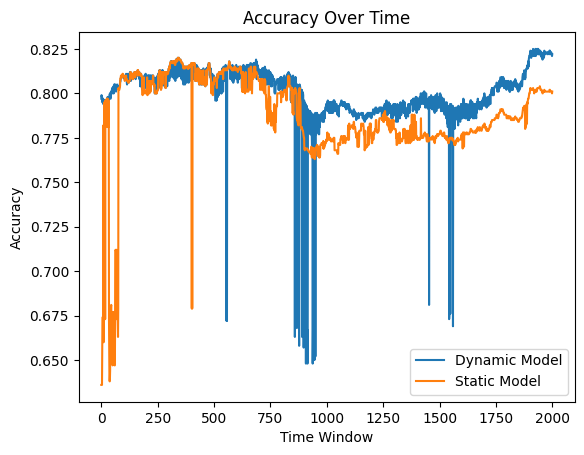

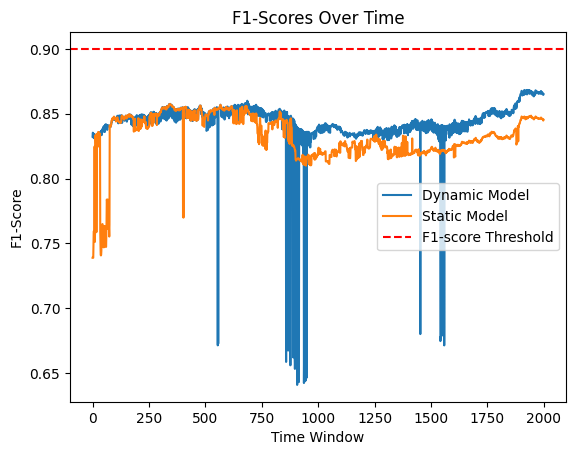

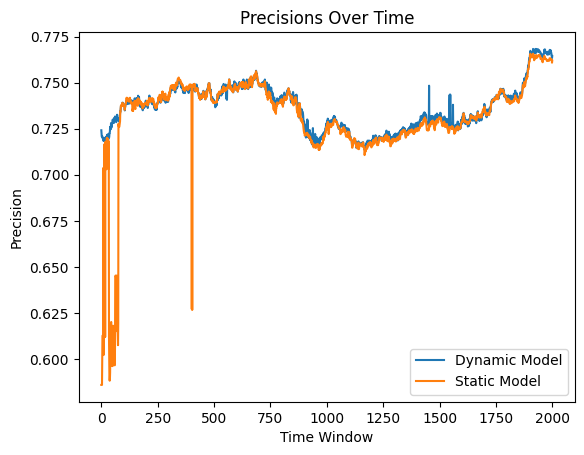

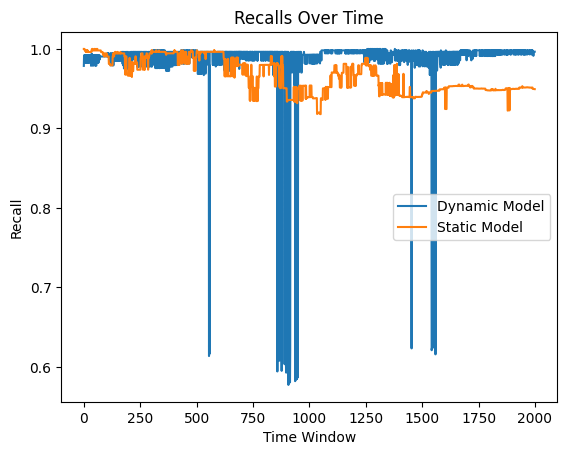

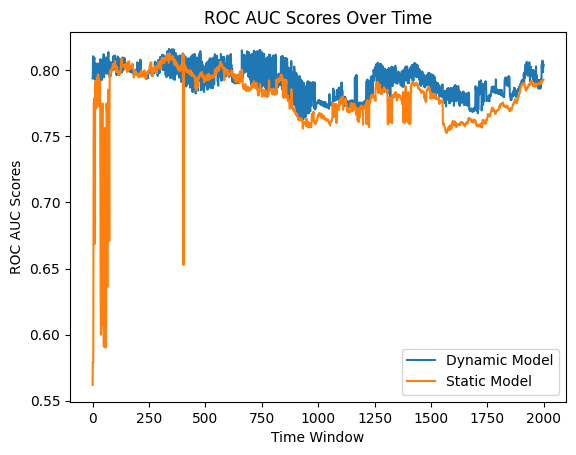

[True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

In [56]:
# Lists to store performance metrics
dynamic_accuracies = []
static_accuracies = []
dynamic_precisions = []
static_precisions = []
dynamic_recalls = []
static_recalls = []
dynamic_f1_scores = []
static_f1_scores = []
dynamic_roc_auc_scores = []
static_roc_auc_scores = []
time_windows = []

# Decision boundary threshold for retraining
F1_SCORE_THRESHOLD = 0.9
RETRAIN_DECISIONS = []

# Simulate streaming data and model evaluation over 2000 windows
for i in range(2000):  
    # Stream data 
    data_window = stream_data_from_kafka(consumer)
    
    # Evaluate the dynamic model's performance
    dynamic_accuracy,dynamic_precision,dynamic_recall,dynamic_f1,dynamic_roc_auc = evaluate_model(dynamic_xgboost_model, data_window)
    dynamic_accuracies.append(dynamic_accuracy)
    dynamic_precisions.append(dynamic_precision)
    dynamic_recalls.append(dynamic_recall)
    dynamic_f1_scores.append(dynamic_f1)
    dynamic_roc_auc_scores.append(dynamic_roc_auc)
    
    # Evaluate another model's performance
    static_accuracy,static_precision,static_recall,static_f1,static_roc_auc = evaluate_model(static_xgboost_model, data_window)
    static_accuracies.append(static_accuracy)
    static_precisions.append(static_precision)
    static_recalls.append(static_recall)
    static_f1_scores.append(static_f1)
    static_roc_auc_scores.append(static_roc_auc)
    
    # Check the decision boundary for retraining
    if dynamic_f1[0] < F1_SCORE_THRESHOLD:
        RETRAIN_DECISIONS.append(True)
        retrain_model(dynamic_xgboost_model, data_window)
    else:
        RETRAIN_DECISIONS.append(False)
    
    time_windows.append(i)

# Plot the performances
plt.plot(time_windows, dynamic_accuracies, label="Dynamic Model")
plt.plot(time_windows, static_accuracies, label="Static Model")
plt.title("Accuracy Over Time")
plt.xlabel("Time Window")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot F1-Scores
plt.plot(time_windows, dynamic_f1_scores, label="Dynamic Model")
plt.plot(time_windows, static_f1_scores, label="Static Model")
plt.axhline(y=F1_SCORE_THRESHOLD, color='r', linestyle='--', label="F1-score Threshold")
plt.title("F1-Scores Over Time")
plt.xlabel("Time Window")
plt.ylabel("F1-Score")
plt.legend()
plt.show()

# Plot Precisions
plt.plot(time_windows, dynamic_precisions, label="Dynamic Model")
plt.plot(time_windows, static_precisions, label="Static Model")
plt.title("Precisions Over Time")
plt.xlabel("Time Window")
plt.ylabel("Precision")
plt.legend()
plt.show()

# Plot Recalls
plt.plot(time_windows, dynamic_recalls, label="Dynamic Model")
plt.plot(time_windows, static_recalls, label="Static Model")
plt.title("Recalls Over Time")
plt.xlabel("Time Window")
plt.ylabel("Recall")
plt.legend()
plt.show()

# Plot ROC AUC Scores
plt.plot(time_windows, dynamic_roc_auc_scores, label="Dynamic Model")
plt.plot(time_windows, static_roc_auc_scores, label="Static Model")
plt.title("ROC AUC Scores Over Time")
plt.xlabel("Time Window")
plt.ylabel("ROC AUC Scores")
plt.legend()
plt.show()

RETRAIN_DECISIONS

We tried a lower threshold of F-1 score to see how the dynamic model performs

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Jacky\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


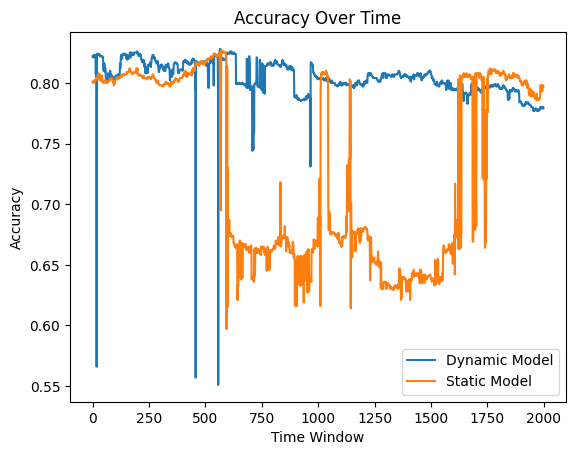

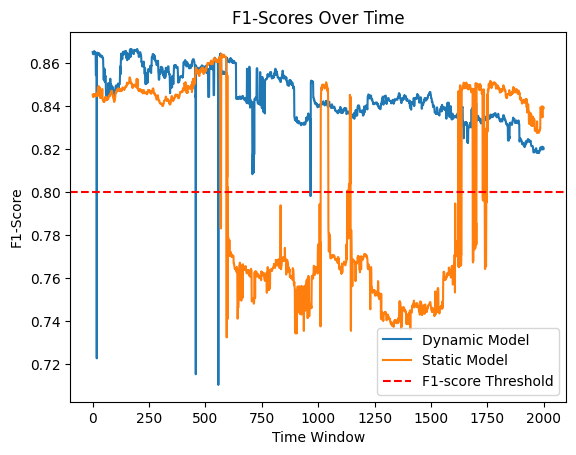

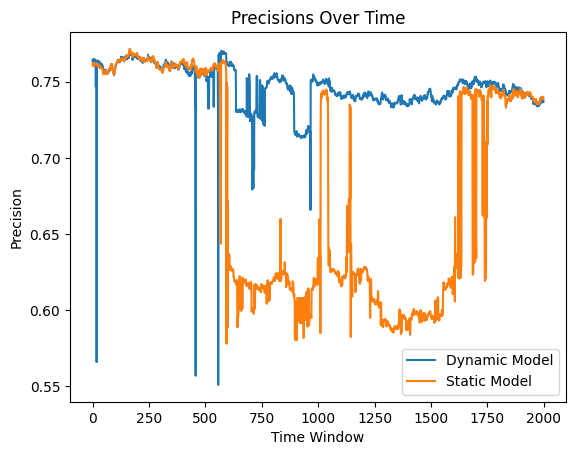

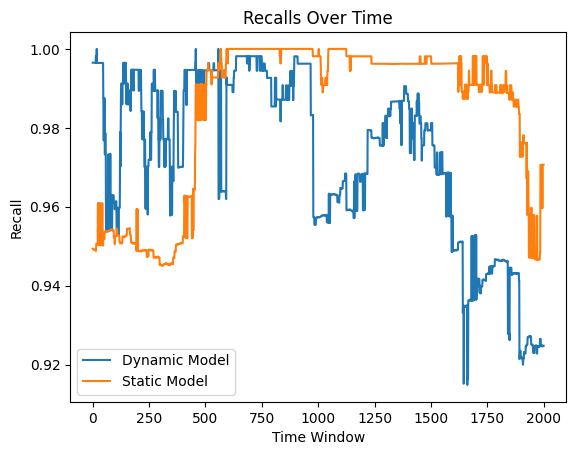

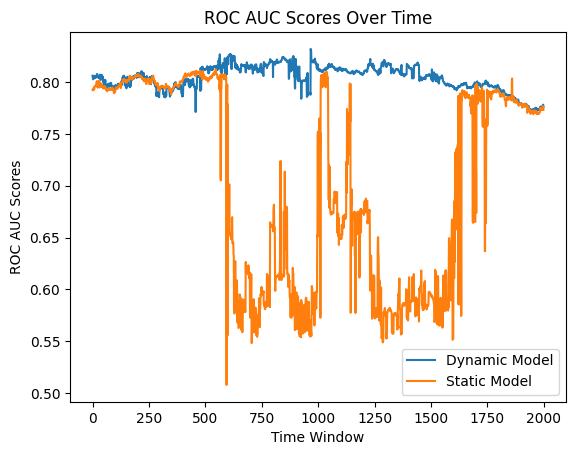

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 

In [57]:
# Lists to store performance metrics
dynamic_accuracies = []
static_accuracies = []
dynamic_precisions = []
static_precisions = []
dynamic_recalls = []
static_recalls = []
dynamic_f1_scores = []
static_f1_scores = []
dynamic_roc_auc_scores = []
static_roc_auc_scores = []
time_windows = []

# Decision boundary threshold for retraining
F1_SCORE_THRESHOLD = 0.8
RETRAIN_DECISIONS = []


# Simulate streaming data and model evaluation over 2000 windows
for i in range(2000):  
    # Stream data 
    data_window = stream_data_from_kafka(consumer)
    
    # Evaluate the dynamic model's performance
    dynamic_accuracy,dynamic_precision,dynamic_recall,dynamic_f1,dynamic_roc_auc = evaluate_model(dynamic_xgboost_model, data_window)
    dynamic_accuracies.append(dynamic_accuracy)
    dynamic_precisions.append(dynamic_precision)
    dynamic_recalls.append(dynamic_recall)
    dynamic_f1_scores.append(dynamic_f1)
    dynamic_roc_auc_scores.append(dynamic_roc_auc)
    
    # Evaluate another model's performance
    static_accuracy,static_precision,static_recall,static_f1,static_roc_auc = evaluate_model(static_xgboost_model, data_window)
    static_accuracies.append(static_accuracy)
    static_precisions.append(static_precision)
    static_recalls.append(static_recall)
    static_f1_scores.append(static_f1)
    static_roc_auc_scores.append(static_roc_auc)
    
    # Check the decision boundary for retraining
    if dynamic_f1[0] < F1_SCORE_THRESHOLD:
        RETRAIN_DECISIONS.append(True)
        retrain_model(dynamic_xgboost_model, data_window)
    else:
        RETRAIN_DECISIONS.append(False)
    
    time_windows.append(i)

# Plot the performances
plt.plot(time_windows, dynamic_accuracies, label="Dynamic Model")
plt.plot(time_windows, static_accuracies, label="Static Model")
plt.title("Accuracy Over Time")
plt.xlabel("Time Window")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Plot F1-Scores
plt.plot(time_windows, dynamic_f1_scores, label="Dynamic Model")
plt.plot(time_windows, static_f1_scores, label="Static Model")
plt.axhline(y=F1_SCORE_THRESHOLD, color='r', linestyle='--', label="F1-score Threshold")
plt.title("F1-Scores Over Time")
plt.xlabel("Time Window")
plt.ylabel("F1-Score")
plt.legend()
plt.show()

# Plot Precisions
plt.plot(time_windows, dynamic_precisions, label="Dynamic Model")
plt.plot(time_windows, static_precisions, label="Static Model")
plt.title("Precisions Over Time")
plt.xlabel("Time Window")
plt.ylabel("Precision")
plt.legend()
plt.show()

# Plot Recalls
plt.plot(time_windows, dynamic_recalls, label="Dynamic Model")
plt.plot(time_windows, static_recalls, label="Static Model")
plt.title("Recalls Over Time")
plt.xlabel("Time Window")
plt.ylabel("Recall")
plt.legend()
plt.show()

# Plot ROC AUC Scores
plt.plot(time_windows, dynamic_roc_auc_scores, label="Dynamic Model")
plt.plot(time_windows, static_roc_auc_scores, label="Static Model")
plt.title("ROC AUC Scores Over Time")
plt.xlabel("Time Window")
plt.ylabel("ROC AUC Scores")
plt.legend()
plt.show()

RETRAIN_DECISIONS